# Proyek Sistem Rekomendasi : Sistem rekomendasi Anime
- Nama : Andi Sadapotto
- Email : andi.sadapotto.m@gmail.com
- ID Dicoding : andi_sadapotto

In [2]:
!pip install fake-useragent
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357269 sha256=68b7b49bc9b5366c05b1ee37f2ea16d6fec1e645c3487d21c4d8c66b6230154e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## Import package & library

In [3]:
import seaborn as sns
import pandas as pd
import requests
import shutil
import numpy as np
import os
import zipfile
import tensorflow as tf


from PIL import Image, UnidentifiedImageError
from matplotlib import pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

## Data Loading

### Download dan ekstrak dataset
Download dataset dari sistus penyedia kaggle kemudian mengekstrak dan menyimpan dataset kedalam folder dataset

In [4]:
# Download  dataset
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/marlesson/myanimelist-dataset-animes-profiles-reviews

# Ekstrak  dataset
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')  # Ekstrak ke folder 'dataset'

# Hapus file zipe
os.remove('archive.zip')

#Tampilkan list konten dari folder 'dataset'
!ls -l dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  216M  100  216M    0     0  17.9M      0  0:00:12  0:00:12 --:--:-- 20.4M
total 690104
-rw-r--r-- 1 root root  12073332 Nov 25 06:45 animes.csv
-rw-r--r-- 1 root root   8664114 Nov 25 06:45 profiles.csv
-rw-r--r-- 1 root root 685916744 Nov 25 06:45 reviews.csv


### Load dataset

In [5]:
df_anime = pd.read_csv('dataset/animes.csv')
df_review = pd.read_csv('dataset/reviews.csv')
df_user = pd.read_csv('dataset/profiles.csv')

In [6]:
df_review.head()

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


## Data Undestanding

Menampilkan jumlah baris dan kolom tiap dataset

In [7]:
# Tampilkan jumlah data dan kolom untuk masing-masing dataset
print("Jumlah data dan kolom df_anime:")
print(df_anime.shape)
print("\nJumlah data dan kolom df_review:")
print(df_review.shape)
print("\nJumlah data dan kolom df_user:")
df_user.shape

Jumlah data dan kolom df_anime:
(19311, 12)

Jumlah data dan kolom df_review:
(192112, 7)

Jumlah data dan kolom df_user:


(81727, 5)

Menampilkan list variabel tiap dataset

In [8]:
print("List variabel df_anime:")
print(df_anime.columns.tolist())
print("\nList variabel df_review:")
print(df_review.columns.tolist())
print("\nList variabel df_user:")
print(df_user.columns.tolist())

List variabel df_anime:
['uid', 'title', 'synopsis', 'genre', 'aired', 'episodes', 'members', 'popularity', 'ranked', 'score', 'img_url', 'link']

List variabel df_review:
['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link']

List variabel df_user:
['profile', 'gender', 'birthday', 'favorites_anime', 'link']


### Variabel Description

animes.csv memiliki 19311 baris dan 12 kolom dengan deskripsi sebagai berikut

Variable | Keterangan
------|------
uid| Kode unik untuk tiap anime
title| Judul dari anime
synopsis| Ringkasan atau ikhtisar dari sebuah anime
genre| List genre dari anime
aired| Tanggal tayang
episodes| Jumlah episode
members| Total member pada komunitas
popularity| Popularitas di situs MyAnimelist
ranked| Rangking/peringkat di situs MyAnimelist
score| Skor/rating di situs MyAnimelist
img_url|link thumbnail anime
link|link anime di MyAnimelist

reviews.csv memiliki 192112 baris dan 7 kolom dengan deskripsi sebagai berikut

Variable | Keterangan
------|------
uid| id unik untuk masing-masing review
profile| username dari pengguna yang memberikan review
anime_uid| anime uid yang di review
text| text review
score| overall skor review yang diberikan
scores |detail score yang diberikan
link| link detail review

profiles.csv memiliki 81727 baris dan 5 kolom dengan deskripsi sebagai berikut

Variable | Keterangan
------|------
profile | username unik untuk tiap pengguna
gender | jenis kelamin
birthday | tanggal lahir
favorites_anime | list anime favorit
link | link profil pengguna

### Assesing Data

Cek missing value

In [9]:
df_anime.isnull().sum()

,0
uid,0
title,0
synopsis,975
genre,0
aired,0
episodes,706
members,0
popularity,0
ranked,3212
score,579


In [10]:
df_review.isnull().sum()

,0
uid,0
profile,0
anime_uid,0
text,0
score,0
scores,0
link,0


In [11]:
df_user.isnull().sum()

,0
profile,0
gender,27871
birthday,34920
favorites_anime,0
link,0


Cek data duplicate

In [12]:
df_anime.duplicated().sum()

2943

In [13]:
df_review.duplicated().sum()

61593

In [14]:
df_user.duplicated().sum()

33825

### Exploratory Data Analysis (EDA) & Visualisasi Data

#### Dataset Anime

Deskripsi statistik dataset anime

In [15]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19311 entries, 0 to 19310
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   uid         19311 non-null  int64  
 1   title       19311 non-null  object 
 2   synopsis    18336 non-null  object 
 3   genre       19311 non-null  object 
 4   aired       19311 non-null  object 
 5   episodes    18605 non-null  float64
 6   members     19311 non-null  int64  
 7   popularity  19311 non-null  int64  
 8   ranked      16099 non-null  float64
 9   score       18732 non-null  float64
 10  img_url     19131 non-null  object 
 11  link        19311 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 1.8+ MB


In [16]:
df_anime.describe(include='all')

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
count,19311.000000,19311,18336,19311,19311,18605.000000,1.931100e+04,19311.000000,16099.000000,18732.000000,19131,19311
unique,NaN,16214,15194,4851,11127,NaN,NaN,NaN,NaN,NaN,16051,16216
top,NaN,Hakkenden: Touhou Hakken Ibun 2nd Season,No synopsis has been added for this series yet...,['Hentai'],Not available,NaN,NaN,NaN,NaN,NaN,https://cdn.myanimelist.net/images/anime/1071/...,https://myanimelist.net/anime/18055/Hakkenden_...
freq,NaN,3,46,1837,372,NaN,NaN,NaN,NaN,NaN,3,3
mean,19358.904096,NaN,NaN,NaN,NaN,11.460414,3.472609e+04,7720.830304,6866.524194,6.436107,NaN,NaN
std,14271.446515,NaN,NaN,NaN,NaN,47.950386,1.121772e+05,4676.786104,4390.018768,1.007941,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,1.000000,2.500000e+01,1.000000,1.000000,1.250000,NaN,NaN
25%,4833.500000,NaN,NaN,NaN,NaN,1.000000,3.880000e+02,3725.000000,2895.500000,5.770000,NaN,NaN
50%,18327.000000,NaN,NaN,NaN,NaN,2.000000,2.389000e+03,7539.000000,6963.000000,6.410000,NaN,NaN
75%,33896.500000,NaN,NaN,NaN,NaN,12.000000,1.450150e+04,11613.000000,10601.500000,7.150000,NaN,NaN


Grouping berdasarkan genre

In [17]:
df_anime.groupby('genre').count().sort_values(by='uid', ascending=False)

,uid,title,synopsis,aired,episodes,members,popularity,ranked,score,img_url,link
genre,,,,,,,,,,,
['Hentai'],1837,1837,1631,1837,1767,1837,1837,0,1834,1818,1837
['Music'],728,728,708,728,707,728,728,705,705,728,728
['Comedy'],642,642,598,642,625,642,642,639,639,631,642
['Kids'],412,412,364,412,394,412,412,410,410,371,412
['Dementia'],202,202,191,202,202,202,202,202,202,187,202
...,...,...,...,...,...,...,...,...,...,...,...
"['Action', 'Military', 'Comedy', 'Romance']",1,1,1,1,1,1,1,1,1,1,1
"['Comedy', 'Vampire', 'Shoujo']",1,1,1,1,1,1,1,1,1,1,1
"['Action', 'Military', 'Comedy', 'Historical']",1,1,1,1,1,1,1,1,1,1,1


In [18]:
# show data based on ranked
df_anime[['title','ranked']].sort_values(by='ranked', ascending=True)

,title,ranked
3080,Fullmetal Alchemist: Brotherhood,1.0
3,Fullmetal Alchemist: Brotherhood,1.0
773,Steins;Gate,2.0
18281,Steins;Gate,2.0
772,Hunter x Hunter (2011),3.0
...,...,...
17487,Idol Kyousei Sousa,NaN
17488,Aoi Yousei,NaN
17491,Heisei Jogakuen Kagai Lesson,NaN
17492,Gakuen Maria: Bakunyuu Teachers,NaN


In [19]:
df_anime.synopsis.mode()[0]

'No synopsis has been added for this series yet. \r\n \r\n Click here  to update this information.'

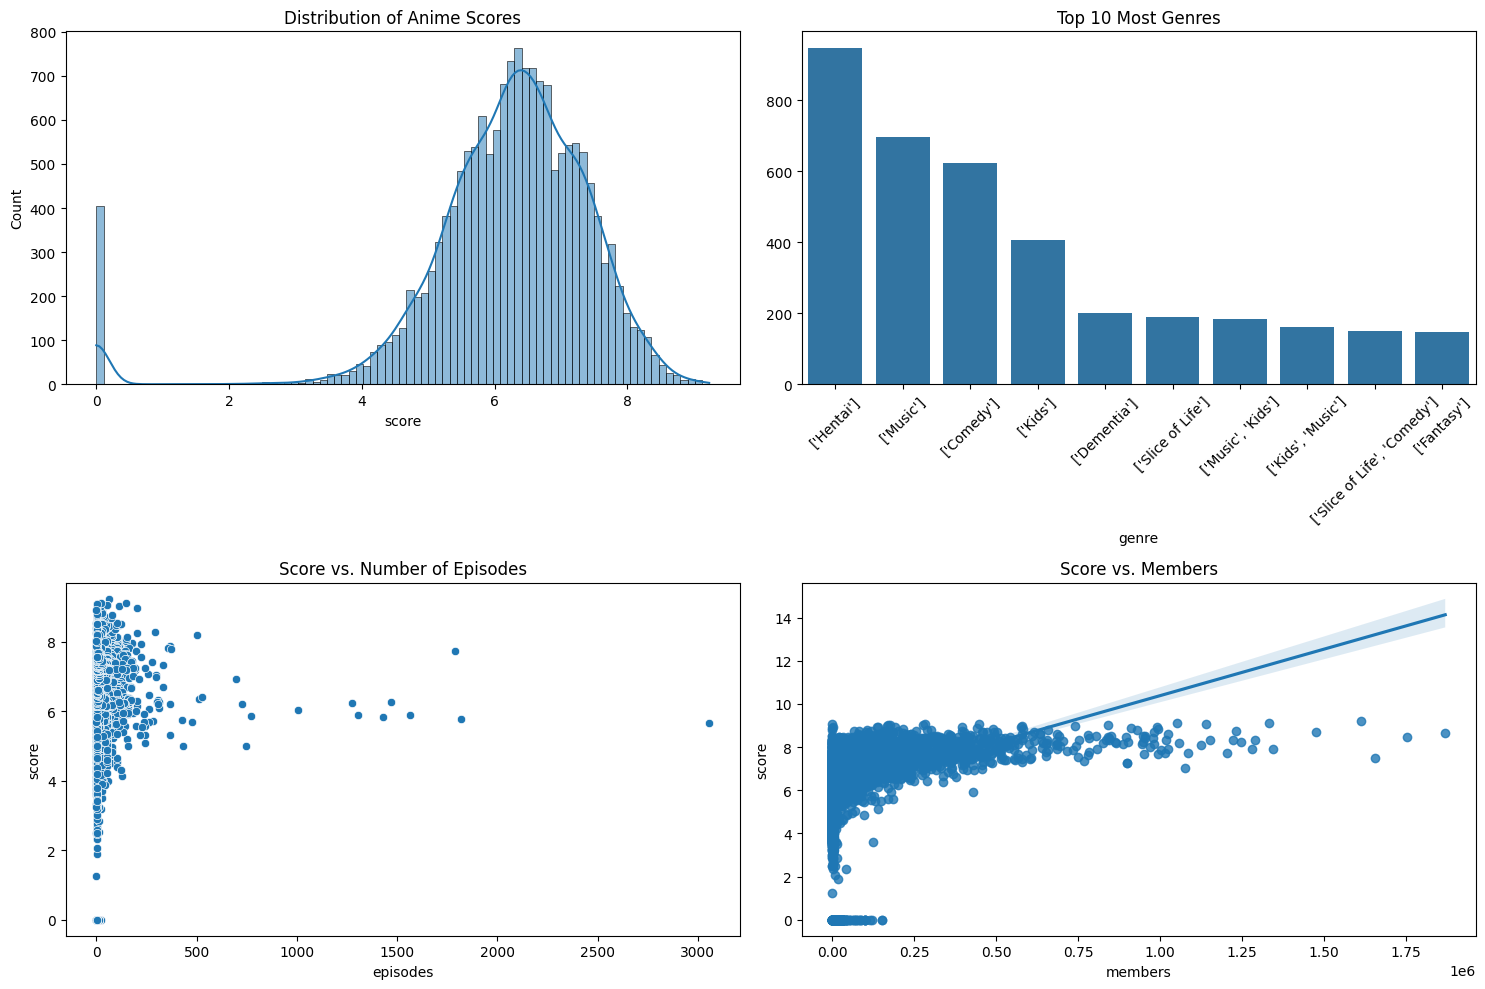

In [56]:
# Create the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribution of Anime Scores
sns.histplot(df_anime['score'].dropna(), kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Anime Scores')

# Plot 2: Top 10 Genres
top_genres = df_anime.groupby('genre').size().sort_values(ascending=False).head(10)
sns.barplot(x=top_genres.index, y=top_genres.values, ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Most Genres')
axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability


# Plot 3: Relationship between Score and Number of Episodes
sns.scatterplot(x='episodes', y='score', data=df_anime.dropna(subset=['episodes', 'score']), ax=axes[1, 0])
axes[1, 0].set_title('Score vs. Number of Episodes')


# Plot 4: Relationship between Score and Members
sns.regplot(x='members', y='score', data=df_anime.dropna(subset=['members', 'score']), ax=axes[1, 1])
axes[1, 1].set_title('Score vs. Members')

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plot
plt.show()

#### Dataset review

In [21]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192112 entries, 0 to 192111
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   uid        192112 non-null  int64 
 1   profile    192112 non-null  object
 2   anime_uid  192112 non-null  int64 
 3   text       192112 non-null  object
 4   score      192112 non-null  int64 
 5   scores     192112 non-null  object
 6   link       192112 non-null  object
dtypes: int64(3), object(4)
memory usage: 10.3+ MB


In [22]:
df_review.describe(include='all')

,uid,profile,anime_uid,text,score,scores,link
count,192112.000000,192112,192112.000000,192112,192112.000000,192112,192112
unique,NaN,47885,NaN,130440,NaN,29837,130519
top,NaN,Sidewinder51,NaN,\n \n \n \n ...,NaN,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=321183
freq,NaN,762,NaN,8,NaN,13900,4
mean,187648.127525,NaN,15273.300283,NaN,7.570235,NaN,NaN
std,98748.902397,NaN,13480.565379,NaN,2.255167,NaN,NaN
min,1.000000,NaN,1.000000,NaN,0.000000,NaN,NaN
25%,101779.500000,NaN,2167.000000,NaN,6.000000,NaN,NaN
50%,210913.500000,NaN,10793.000000,NaN,8.000000,NaN,NaN
75%,270383.000000,NaN,30205.000000,NaN,9.000000,NaN,NaN


In [23]:
df_review.groupby('scores').count().sort_values(by='uid', ascending=False)

,uid,profile,anime_uid,text,score,link
scores,,,,,,
"{'Overall': '10', 'Story': '10', 'Animation': '10', 'Sound': '10', 'Character': '10', 'Enjoyment': '10'}",13900,13900,13900,13900,13900,13900
"{'Overall': '10', 'Story': '10', 'Animation': '9', 'Sound': '10', 'Character': '10', 'Enjoyment': '10'}",2086,2086,2086,2086,2086,2086
"{'Overall': '10', 'Story': '10', 'Animation': '9', 'Sound': '9', 'Character': '10', 'Enjoyment': '10'}",1774,1774,1774,1774,1774,1774
"{'Overall': '8', 'Story': '0', 'Animation': '0', 'Sound': '0', 'Character': '0', 'Enjoyment': '0'}",1528,1528,1528,1528,1528,1528
"{'Overall': '10', 'Story': '9', 'Animation': '10', 'Sound': '10', 'Character': '10', 'Enjoyment': '10'}",1519,1519,1519,1519,1519,1519
...,...,...,...,...,...,...
"{'Overall': '5', 'Story': '5', 'Animation': '7', 'Sound': '7', 'Character': '3', 'Enjoyment': '1'}",1,1,1,1,1,1
"{'Overall': '5', 'Story': '5', 'Animation': '7', 'Sound': '7', 'Character': '2', 'Enjoyment': '3'}",1,1,1,1,1,1
"{'Overall': '5', 'Story': '5', 'Animation': '7', 'Sound': '7', 'Character': '1', 'Enjoyment': '6'}",1,1,1,1,1,1


In [24]:
df_review.groupby('profile').count().sort_values(by='uid', ascending=False)

,uid,anime_uid,text,score,scores,link
profile,,,,,,
Sidewinder51,762,762,762,762,762,762
Stark700,743,743,743,743,743,743
ktulu007,648,648,648,648,648,648
LegendAqua,566,566,566,566,566,566
ggultra2764,491,491,491,491,491,491
...,...,...,...,...,...,...
XxxCMDxxX,1,1,1,1,1,1
Erin50996,1,1,1,1,1,1
XxembermasterxX,1,1,1,1,1,1


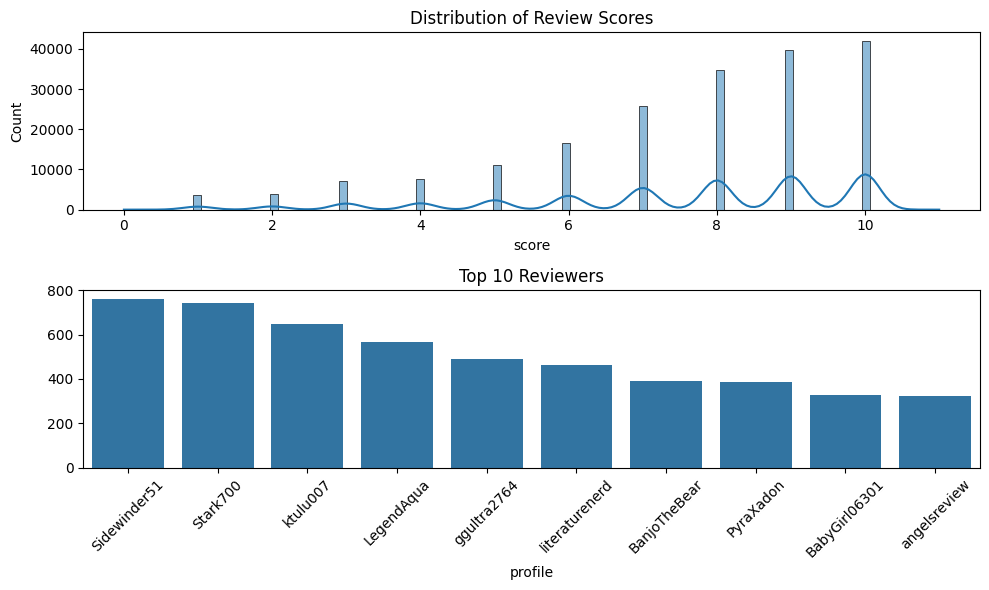

In [25]:
# Create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Plot 1: Distribution of Review Scores
sns.histplot(df_review['score'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Distribution of Review Scores')

# Plot 2: Top 10 Reviewers
top_reviewers = df_review.groupby('profile').size().sort_values(ascending=False).head(10)
sns.barplot(x=top_reviewers.index, y=top_reviewers.values, ax=axes[1])
axes[1].set_title('Top 10 Reviewers')
axes[1].tick_params(axis='x', rotation=45) # Rotate x-axis labels


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#### Dataset profile/user

In [26]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81727 entries, 0 to 81726
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   profile          81727 non-null  object
 1   gender           53856 non-null  object
 2   birthday         46807 non-null  object
 3   favorites_anime  81727 non-null  object
 4   link             81727 non-null  object
dtypes: object(5)
memory usage: 3.1+ MB


In [27]:
df_user.describe(include='all')

,profile,gender,birthday,favorites_anime,link
count,81727,53856,46807,81727,81727
unique,47885,3,7708,35395,47885
top,Voivodian,Male,1995,[],https://myanimelist.net/profile/Voivodian
freq,6,37096,211,16602,6


In [28]:
df_user.groupby('gender').profile.nunique().sort_values(ascending=False)

,profile
gender,
Male,21188
Female,9264
Non-Binary,426


In [29]:
df_user.gender.isnull().sum()

27871

In [30]:
def check_gender_inconsistency(df):
  """
  Checks for inconsistencies in gender information within a DataFrame.

  Args:
    df: A pandas DataFrame containing a 'profile' column and a 'gender' column.

  Returns:
    A pandas Series with profile names that have inconsistent gender information,
    or None if no inconsistencies are found.
  """

  profiles_with_gender = df.dropna(subset=['gender'])['profile'].unique()
  profiles_without_gender = df[df['gender'].isna()]['profile'].unique()

  inconsistent_profiles = set(profiles_with_gender) & set(profiles_without_gender)

  if inconsistent_profiles:
    return pd.Series(list(inconsistent_profiles), name="Inconsistent Profiles")
  else:
    return None

# Example usage (assuming 'df_user' is your DataFrame):
inconsistent_genders = check_gender_inconsistency(df_user)

if inconsistent_genders is not None:
  print("Profiles with inconsistent gender information:")
  print(inconsistent_genders)
else:
  print("No inconsistencies in gender information found.")

No inconsistencies in gender information found.


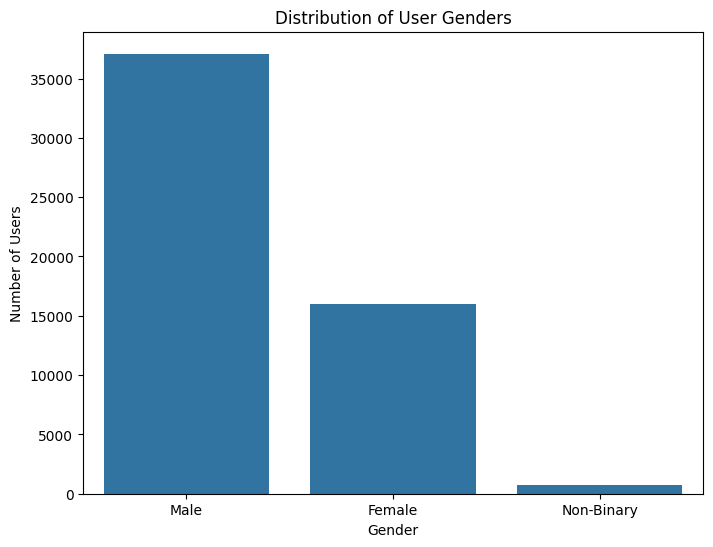

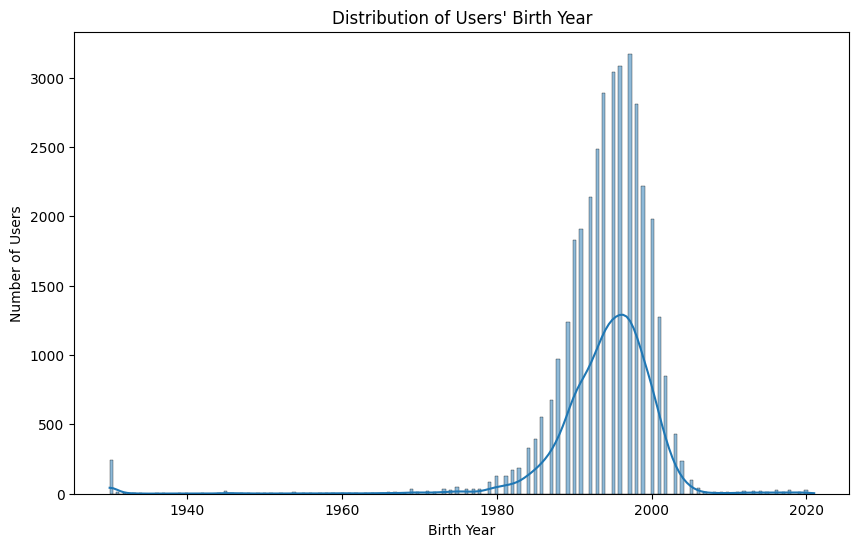

In [31]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of genders
sns.countplot(x='gender', data=df_user, ax=ax)
ax.set_title('Distribution of User Genders')
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Users')

# Show the plot
plt.show()

#Further visualization for user data

#Distribution of users by birthday year
df_user['birthday'] = pd.to_datetime(df_user['birthday'], errors='coerce')
birthyear = df_user['birthday'].dt.year
plt.figure(figsize=(10,6))
sns.histplot(birthyear.dropna(), kde=True)
plt.title("Distribution of Users' Birth Year")
plt.xlabel('Birth Year')
plt.ylabel('Number of Users')
plt.show()

In [43]:
# Group by genre and get the highest score and most reviews for each genre
genre_stats = df_anime.groupby('genre').agg(
    max_score=('score', 'max'),
    review_count=('uid', 'count')
).reset_index()

# Find the genre with the highest score
highest_score_genre = genre_stats.loc[genre_stats['max_score'].idxmax()]

# Find the genre with the most reviews
most_reviews_genre = genre_stats.loc[genre_stats['review_count'].idxmax()]

In [44]:
print("Genre with the highest score:")
highest_score_genre

Genre with the highest score:


,1176
genre,"['Action', 'Military', 'Adventure', 'Comedy', ..."
max_score,9.23
review_count,1


In [45]:
print("Genre with the most reviews:")
most_reviews_genre

Genre with the most reviews:


,3639
genre,['Hentai']
max_score,8.03
review_count,946


In [50]:
# Merge anime and review dataframes
merged_df = pd.merge(df_anime, df_review, left_on='uid', right_on='anime_uid', how='inner')

# Group by genre and calculate the average score and number of reviews
genre_performance = merged_df.groupby('genre').agg(
    avg_score=('score_y', 'mean'),
    num_reviews=('uid_y', 'count')
).reset_index()

# Sort by average score and number of reviews to find the most popular genres
genre_performance = genre_performance.sort_values(by=['avg_score', 'num_reviews'], ascending=False)

genre_performance

,genre,avg_score,num_reviews
783,"['Action', 'Historical', 'Martial Arts', 'Fant...",10.0,3
867,"['Action', 'Martial Arts', 'Mecha', 'Sci-Fi', ...",10.0,2
928,"['Action', 'Military', 'Adventure', 'Mecha']",10.0,2
1465,"['Adventure', 'Comedy', 'Kids', 'Fantasy', 'Me...",10.0,2
1525,"['Adventure', 'Drama', 'Fantasy', 'Historical'...",10.0,2
...,...,...,...
678,"['Action', 'Fantasy', 'Hentai', 'Demons']",1.0,1
1515,"['Adventure', 'Dementia', 'Fantasy']",1.0,1
1740,"['Cars', 'Kids']",1.0,1
3181,"['Parody', 'Super Power', 'Hentai']",1.0,1


In [53]:
# Filter genres with average score greater than 8
top_genres = genre_performance[genre_performance['avg_score'] > 8]

# Explode the 'genre' column to separate genres
top_genres['genre'] = top_genres['genre'].str.split(', ')
exploded_genres = top_genres.explode('genre')

# Count the occurrences of each genre
genre_counts = exploded_genres['genre'].value_counts()

# Get the top 10 genres
top_ten_genres = genre_counts.head(10)

top_ten_genres

<ipython-input-53-895ca821ec7a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_genres['genre'] = top_genres['genre'].str.split(', ')


,count
genre,
['Action',185
'Comedy',165
'Drama',164
'Romance',143
'Shounen'],130
['Comedy',116
'Fantasy',107
'Sci-Fi',97
['Adventure',87


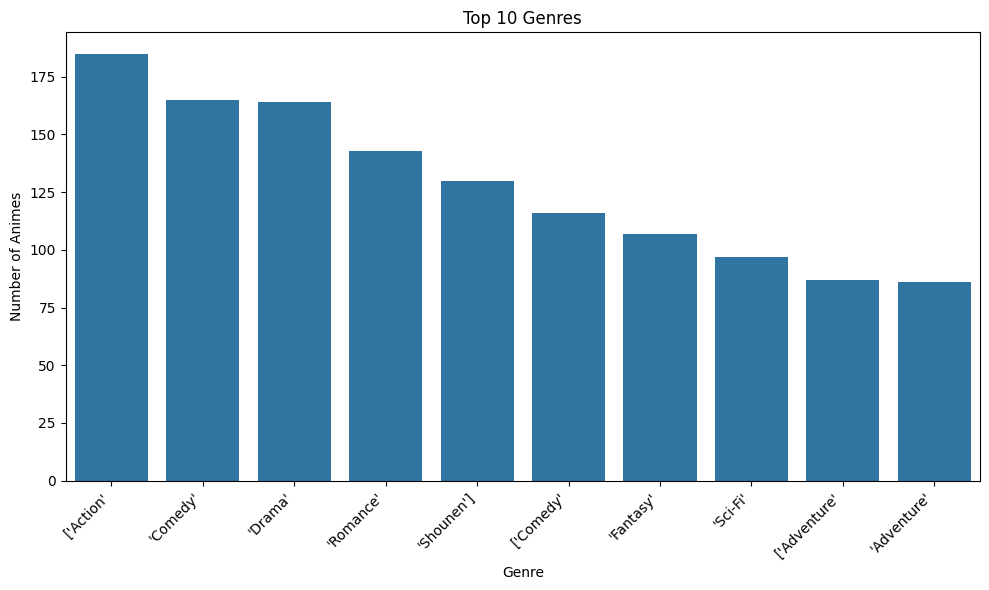

In [55]:
# Create the bar plot for top_ten_genres
plt.figure(figsize=(10, 6))
sns.barplot(x=top_ten_genres.index, y=top_ten_genres.values)
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Animes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Data Preparation

In [32]:
# drop duplicate colomn
df_anime.drop_duplicates(inplace=True)
df_review.drop_duplicates(inplace=True)
df_user.drop_duplicates(inplace=True)

In [33]:
#fill missing value on dataset user
df_user['gender'].fillna('Non-Binary', inplace=True)

#fill missing value on birthday with interpolate
df_user['birthday'].fillna(df_user['birthday'].interpolate(), inplace=True)

# add column age based on birthday
df_user['birthday'] = pd.to_datetime(df_user['birthday'])
# Calculate age using days and dividing by 365.25 to approximate years
df_user['age'] = (pd.to_datetime('today') - df_user['birthday']).dt.days / 365.25
df_user['age'] = df_user['age'].astype(int)

# Fill missing values, incrementing the rank for each missing value
next_rank = df_anime['ranked'].max() + 1 if not pd.isna(df_anime['ranked'].max()) else 1

df_anime['ranked'] = df_anime['ranked'].fillna(next_rank + df_anime['ranked'].isnull().cumsum())
df_anime['ranked'] = df_anime['ranked'].astype(int)

# fill missing value on synopsis with mode
df_anime.synopsis.fillna(df_anime.synopsis.mode()[0], inplace=True)

# fill missing value on score with zero
df_anime.score.fillna(0, inplace=True)

# fill missing values episodes to -1
df_anime.episodes.fillna(-1, inplace=True)

<ipython-input-33-63d44971df27>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_user['gender'].fillna('Non-Binary', inplace=True)
<ipython-input-33-63d44971df27>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [34]:
df_anime

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...
...,...,...,...,...,...,...,...,...,...,...,...,...
19002,10075,Naruto x UT,All-new animation offered throughout UNIQLO cl...,"['Action', 'Comedy', 'Super Power', 'Martial A...","Jan 1, 2011",1.0,34155,2382,1728,7.50,https://cdn.myanimelist.net/images/anime/3/304...,https://myanimelist.net/anime/10075/Naruto_x_UT
19003,35828,Miira no Kaikata,High school student Sora Kashiwagi is accustom...,"['Slice of Life', 'Comedy', 'Supernatural']","Jan 12, 2018 to Mar 30, 2018",12.0,61459,1648,1727,7.50,https://cdn.myanimelist.net/images/anime/1486/...,https://myanimelist.net/anime/35828/Miira_no_K...
19004,10378,Shinryaku!? Ika Musume,"After regaining her squid-like abilities, Ika ...","['Slice of Life', 'Comedy', 'Shounen']","Sep 27, 2011 to Dec 25, 2011",12.0,67422,1547,1548,7.56,https://cdn.myanimelist.net/images/anime/6/301...,https://myanimelist.net/anime/10378/Shinryaku_...
19005,33082,Kingsglaive: Final Fantasy XV,"For years, the Niflheim Empire and the kingdom...",['Action'],"Jul 9, 2016",1.0,41077,2154,1544,7.56,https://cdn.myanimelist.net/images/anime/12/79...,https://myanimelist.net/anime/33082/Kingsglaiv...


In [35]:
df_anime.isnull().sum()

,0
uid,0
title,0
synopsis,0
genre,0
aired,0
episodes,0
members,0
popularity,0
ranked,0
score,0


In [36]:
df_user

,profile,gender,birthday,favorites_anime,link,age
0,DesolatePsyche,Male,1994-10-02 00:00:00,"['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche,30
1,baekbeans,Female,2000-11-10 00:00:00,"['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans,24
2,skrn,Non-Binary,2000-07-07 08:00:00,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn,24
3,edgewalker00,Male,2000-03-03 16:00:00,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00,24
4,aManOfCulture99,Male,1999-10-30 00:00:00,"['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99,25
...,...,...,...,...,...,...
77656,daniel1302,Non-Binary,1996-04-14 08:00:00,[],https://myanimelist.net/profile/daniel1302,28
77657,bridgesams,Male,2001-01-01 00:00:00,"['37510', '35180', '30', '31043', '5081', '374...",https://myanimelist.net/profile/bridgesams,23
77659,Officer_Anime,Non-Binary,2001-01-01 00:00:00,[],https://myanimelist.net/profile/Officer_Anime,23
77660,Yuez,Non-Binary,2001-01-01 00:00:00,[],https://myanimelist.net/profile/Yuez,23


In [37]:
df_review

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149
...,...,...,...,...,...,...,...
182629,146535,iHitokage,2593,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=146535
182631,13126,Onegai,2593,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '6', 'Animation': '9...",https://myanimelist.net/reviews.php?id=13126
182633,127899,Murasa22,2593,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '9', 'Animation': '...",https://myanimelist.net/reviews.php?id=127899
182636,286852,srry4apologizng,2593,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '5', 'Animation': '1...",https://myanimelist.net/reviews.php?id=286852


In [38]:
# prepare dataset for collaborative filtering

df_review_anime = df_review.copy()
df_review_anime.rename(columns={'score':'user_scored'}, inplace=True)
df_review_anime.drop(columns=['text','uid','scores','link'], inplace=True)
df_review_anime = pd.merge(df_review_anime, df_anime[['uid','title','genre','img_url','score']], left_on='anime_uid', right_on='uid', how='left')
df_review_anime


,profile,anime_uid,user_scored,uid,title,genre,img_url,score
0,DesolatePsyche,34096,8,34096,Gintama.,"['Action', 'Comedy', 'Historical', 'Parody', '...",https://cdn.myanimelist.net/images/anime/3/835...,8.94
1,baekbeans,34599,10,34599,Made in Abyss,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",https://cdn.myanimelist.net/images/anime/6/867...,8.83
2,skrn,28891,7,28891,Haikyuu!! Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",https://cdn.myanimelist.net/images/anime/9/766...,8.82
3,edgewalker00,2904,9,2904,Code Geass: Hangyaku no Lelouch R2,"['Action', 'Military', 'Sci-Fi', 'Super Power'...",https://cdn.myanimelist.net/images/anime/4/939...,8.93
4,aManOfCulture99,4181,10,4181,Clannad: After Story,"['Slice of Life', 'Comedy', 'Supernatural', 'D...",https://cdn.myanimelist.net/images/anime/13/24...,8.97
...,...,...,...,...,...,...,...,...
131861,iHitokage,2593,10,2593,Kara no Kyoukai 1: Fukan Fuukei,"['Action', 'Mystery', 'Supernatural', 'Thriller']",https://cdn.myanimelist.net/images/anime/12/21...,7.70
131862,Onegai,2593,7,2593,Kara no Kyoukai 1: Fukan Fuukei,"['Action', 'Mystery', 'Supernatural', 'Thriller']",https://cdn.myanimelist.net/images/anime/12/21...,7.70
131863,Murasa22,2593,10,2593,Kara no Kyoukai 1: Fukan Fuukei,"['Action', 'Mystery', 'Supernatural', 'Thriller']",https://cdn.myanimelist.net/images/anime/12/21...,7.70
131864,srry4apologizng,2593,9,2593,Kara no Kyoukai 1: Fukan Fuukei,"['Action', 'Mystery', 'Supernatural', 'Thriller']",https://cdn.myanimelist.net/images/anime/12/21...,7.70


In [39]:
df_review_anime.isnull().sum()

,0
profile,0
anime_uid,0
user_scored,0
uid,0
title,0
genre,0
img_url,13
score,0


In [84]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_anime['genre'])

In [85]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df_review_anime['genre'].apply(lambda x: x.replace("[", "").replace("]", "").replace("'", "").split(", ")))

# Create a DataFrame for the encoded genres
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df_review_anime.index)

# Concatenate the encoded genres with the existing DataFrame
df_review_anime = pd.concat([df_review_anime, genre_df], axis=1)

In [89]:
# define rating scale
rating_scale = Reader(rating_scale=(0, 10))

# load data
data = Dataset.load_from_df(df_review_anime[['profile', 'title', 'user_scored',]], rating_scale)

# split dataset
train_set, test_set = surprise_train_test_split(data, test_size=0.20, random_state=42)

In [90]:
# Convert categorical data (profile and title) to numerical representations
user_ids = df_review_anime['profile'].unique()
anime_ids = df_review_anime['title'].unique()

user_to_index = {user: index for index, user in enumerate(user_ids)}
anime_to_index = {anime: index for index, anime in enumerate(anime_ids)}

df_review_anime['user_index'] = df_review_anime['profile'].map(user_to_index)
df_review_anime['anime_index'] = df_review_anime['title'].map(anime_to_index)

# Prepare data for the model
X = df_review_anime[['user_index', 'anime_index']].values
y = df_review_anime['user_scored'].values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

### Content Based

In [91]:
def content_based_recommender(df, title, top_n=10):
    df = df.copy()
    try:
      # Compute cosine similarity matrix
      cosine_sim = cosine_similarity(tfidf_matrix)

      # Get the index of the anime with the given title
      indices = pd.Series(df.index, index=df['title']).drop_duplicates()

      # Function that takes in anime title as input and outputs most similar anime
      idx = indices[title]
      sim_scores = list(enumerate(cosine_sim[idx]))
      sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
      sim_scores = sim_scores[1:top_n+1]  # Exclude the anime itself
      anime_indices = [i[0] for i in sim_scores]

      # Return recommended anime titles with similarity scores
      recommendations = df['title'].iloc[anime_indices].reset_index(drop=True)
      recommendations_df = pd.DataFrame({'title': recommendations, 'Similarity Score': [i[1] for i in sim_scores]})

      return recommendations_df

    except Exception as e:
      print(f"An error occurred: {e}")
      return FileNotFoundError

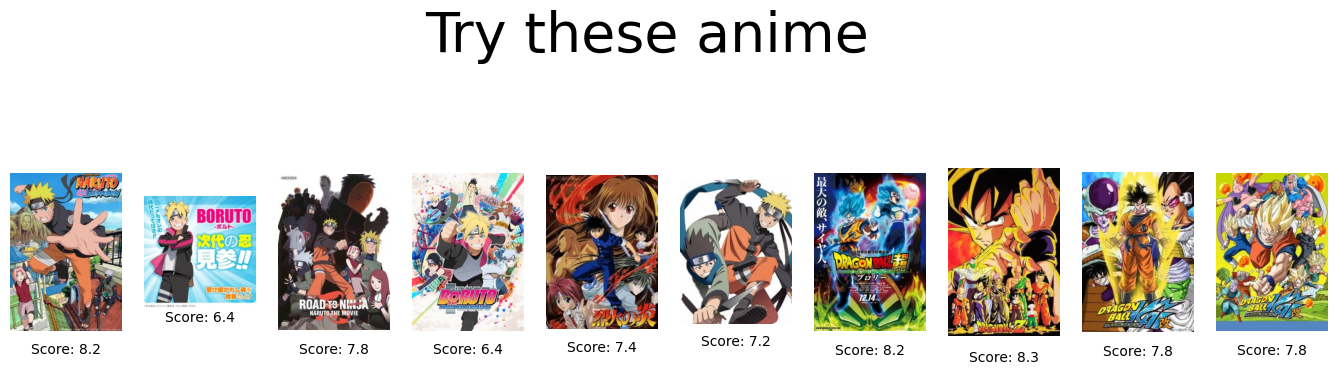

In [92]:
from fake_useragent import UserAgent

ua = UserAgent()

n=10
top_ten=content_based_recommender(df_anime, 'Naruto', top_n=n)
fig,ax=plt.subplots(1,10,figsize=(17,5))
fig.suptitle("Try these anime",fontsize=40)
if top_ten is None:
    print("No recommendations found.")
else:
  for i in range(len(top_ten["title"].tolist())):
      url=df_anime.loc[df_anime["title"]==top_ten["title"].tolist()[i],"img_url"][:1].values[0]
      try:
          headers = {'User-Agent': ua.random}
          response = requests.get(url, stream=True, headers=headers)
          response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)
          img = Image.open(response.raw)
      except requests.exceptions.RequestException as e:
          print(f"Error downloading image from {url}: {e}")
          continue  # Skip to the next image if download fails
      except UnidentifiedImageError as e:
          print(f"Error opening image from {url}: {e}")
          continue  # Skip to the next image if opening fails
      except Exception as e:
          print(f"An unexpected error occurred: {e}")
          continue  # Skip to the next image if any other error occurs
      ax[i].imshow(img)
      ax[i].axis("off")
      ax[i].set_title("Score: {}".format(round(df_anime[df_anime["title"]==top_ten["title"].tolist()[i]]["score"].mean(),1)),y=-0.20,fontsize=10)
      fig.show()

### Colaborative filtering

#### SVD

In [93]:
model_svd = SVD()

In [94]:
model_svd.fit(train_set)

In [95]:
predictions_svd = model_svd.test(test_set)

In [96]:
def collaborative_recommender(df, profile, top_n=10):
  all_anime = df['title'].unique()
  rated_anime = df[df['profile'] == profile]['title'].unique()
  unrated_anime = np.setdiff1d(all_anime, rated_anime)
  predictions = [model_svd.predict(profile, anime) for anime in unrated_anime]
  predictions.sort(key=lambda x: x.est, reverse=True)
  top_n_predictions = predictions[:top_n]
  return [(pred.iid, pred.est) for pred in top_n_predictions]

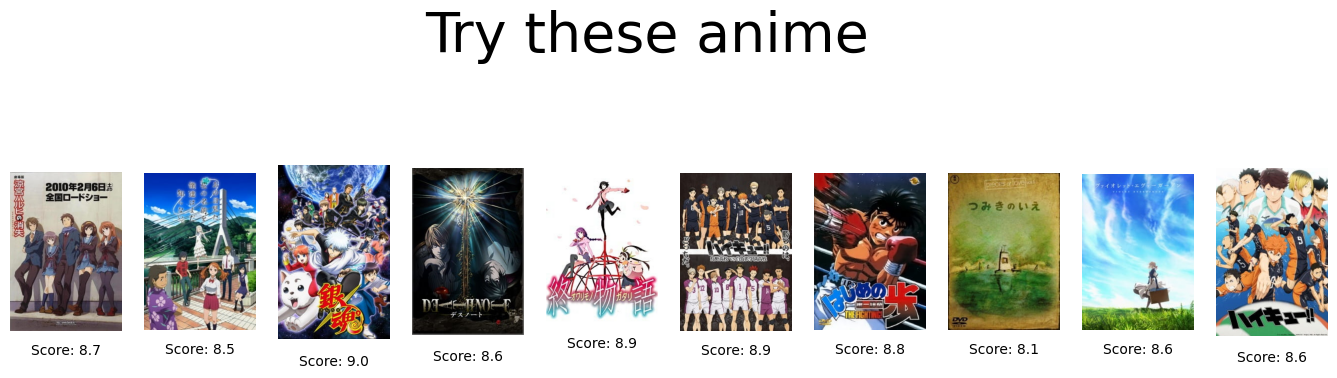

In [97]:
top_ten=collaborative_recommender(df_review_anime, 'Yuez', top_n=10)

fig,ax=plt.subplots(1,10,figsize=(17,5))
fig.suptitle("Try these anime",fontsize=40)
if top_ten is None:
    print("No recommendations found.")
else:
  for i in range(len(top_ten)):
      title = top_ten[i][0]
      url=df_review_anime.loc[df_review_anime["title"]==title,"img_url"][:1].values[0]

      try:
          headers = {'User-Agent': ua.random}
          response = requests.get(url, stream=True, headers=headers)
          response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)
          img = Image.open(response.raw)
      except requests.exceptions.RequestException as e:
          print(f"Error downloading image from {url}: {e}")
          continue  # Skip to the next image if download fails
      except UnidentifiedImageError as e:
          print(f"Error opening image from {url}: {e}")
          continue  # Skip to the next image if opening fails
      except Exception as e:
          print(f"An unexpected error occurred: {e}")
          continue  # Skip to the next image if any other error occurs
      ax[i].imshow(img)
      ax[i].axis("off")
      ax[i].set_title("Score: {}".format(round(df_anime[df_anime["title"]==title]["score"].mean(),1)),y=-0.20,fontsize=10)
      fig.show()

#### Neural network

In [98]:
# Input for user index
user_input = tf.keras.layers.Input(shape=(1,))
user_embedding = tf.keras.layers.Embedding(len(user_ids), 64)(user_input)
user_embedding = tf.keras.layers.Flatten()(user_embedding)

# Input for genre features
genre_input = tf.keras.layers.Input(shape=(genre_encoded.shape[1],))  # Shape based on encoded genre features

# Concatenate user and genre features
merged_features = tf.keras.layers.concatenate([user_embedding, genre_input])

# Hidden layers with regularization and dropout
hidden_layer1 = tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.005))(merged_features)
hidden_layer1 = tf.keras.layers.Dropout(0.4)(hidden_layer1)
hidden_layer2 = tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hidden_layer1)
hidden_layer2 = tf.keras.layers.Dropout(0.2)(hidden_layer2)  # Add dropout
hidden_layer3 = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hidden_layer2)
hidden_layer3 = tf.keras.layers.Dropout(0.2)(hidden_layer3)  # Add dropout

# Output layer
output = tf.keras.layers.Dense(1)(hidden_layer3)

# Create the model
model = tf.keras.Model(inputs=[user_input, genre_input], outputs=output)

In [99]:
# define callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)


In [100]:
# Compile the model
model.compile(
      optimizer='sgd',
      loss= 'mae',
      metrics= ['mae'],
    )

In [101]:
# Prepare training data
X_train_user = X_train[:, 0].reshape(-1, 1)  # User index
X_train_genre = df_review_anime.loc[X_train_user.flatten(), mlb.classes_.tolist()].values # Genre features for training data

# Fit the model with user and genre inputs
history = model.fit(
    [X_train_user, X_train_genre],  # Input: user index and genre features
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,reduce_learning_rate]
)

Epoch 1/20
2638/2638 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 6.9427 - mae: 2.1107 - val_loss: 4.1411 - val_mae: 1.8167 - learning_rate: 0.0100
Epoch 2/20
2638/2638 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 3.7450 - mae: 1.8621 - val_loss: 2.7592 - val_mae: 1.8175 - learning_rate: 0.0100
Epoch 3/20
2638/2638 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.6102 - mae: 1.8373 - val_loss: 2.2075 - val_mae: 1.7993 - learning_rate: 0.0100
Epoch 4/20
2638/2638 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 2.1889 - mae: 1.8486 - val_loss: 1.9942 - val_mae: 1.8036 - learning_rate: 0.0100
Epoch 5/20
2638/2638 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.9944 - mae: 1.8329 - val_loss: 1.8919 - val_mae: 1.7958 - learning_rate: 0.0100
Epoch 6/20
2638/2638 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.9204 - mae: 1.8379 - val_loss: 1.8519 - val_mae: 1.8002 - learning_rate: 0.0100
Epoch 7/20
2638/2638 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.8676 - mae: 1.8226 - val_loss: 1.8371 - val_mae: 1.8079 - learning_

In [102]:
# 5. Make recommendations (example)
def neural_network_recommender(user_profile, top_n=10):
    user_idx = user_to_index.get(user_profile)
    if user_idx is None:
        return "User not found"

    unrated_anime_indices = [anime_to_index[anime] for anime in anime_ids if anime not in df_review_anime[df_review_anime['profile']==user_profile]['title'].values]

    # Get genre features for unrated anime
    unrated_anime_genres = df_review_anime.loc[[anime_to_index[anime] for anime in anime_ids if anime not in df_review_anime[df_review_anime['profile']==user_profile]['title'].values] , mlb.classes_.tolist()].values # Genre features for unrated anime

    # Prepare inputs for prediction
    user_input = np.array([user_idx] * len(unrated_anime_indices)).reshape(-1, 1)  # Repeat user_idx for each anime

    # Predict using both user and genre features
    predictions = model.predict([user_input, unrated_anime_genres])

    top_anime_indices = np.argsort(predictions, axis=0)[-top_n:][::-1]  # Get top N indices from sorted array
    top_anime = [anime_ids[idx] for idx in top_anime_indices.flatten()]

    return top_anime

In [103]:
top_10_nn = neural_network_recommender("Yuez", top_n=10)

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [104]:
top_10_nn

['Angel Core: Tenshi-tachi no Sumika',
 'M.E.M.: Yogosareta Junketsu',
 'Mahou Shoujo Meruru',
 'Fujimi 2-choume Koukyougakudan',
 'Yunyun☆Paradise',
 'Gedou Gakuen',
 'Lunatic Night',
 'Eun-sil-i',
 'Cyborg Kuro-chan',
 'Fake Style']

## Evaluation

In [105]:
accuracy.mae(predictions_svd)

MAE:  1.5072


1.5071743372206834

In [106]:
accuracy.rmse(predictions_svd)

RMSE: 1.9618


1.961848952760387

In [107]:
#For Neural Network
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Prepare test data
X_test_user = X_test[:, 0].reshape(-1, 1)  # User index
X_test_genre = df_review_anime.loc[X_test_user.flatten(), mlb.classes_.tolist()].values  # Genre features for test data

# Make predictions
y_pred = model.predict([X_test_user, X_test_genre])

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"Neural Network MAE: {mae}")
print(f"Neural Network RMSE: {rmse}")

825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Neural Network MAE: 1.8143914995738046
Neural Network RMSE: 2.3951283952993982


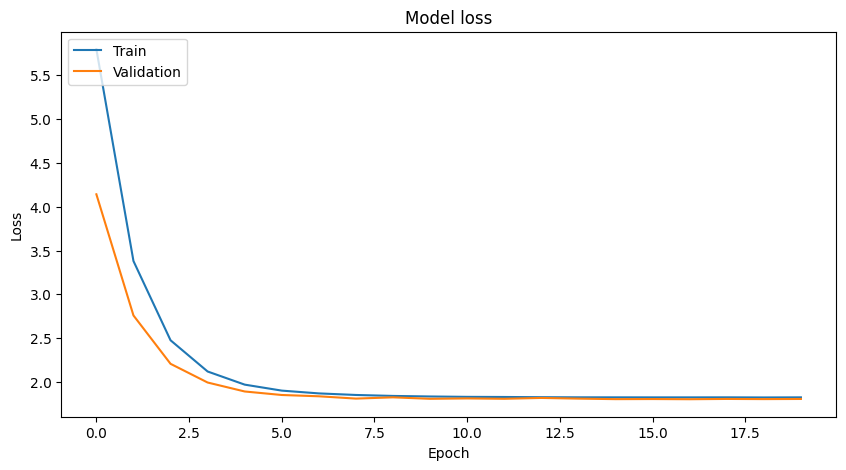

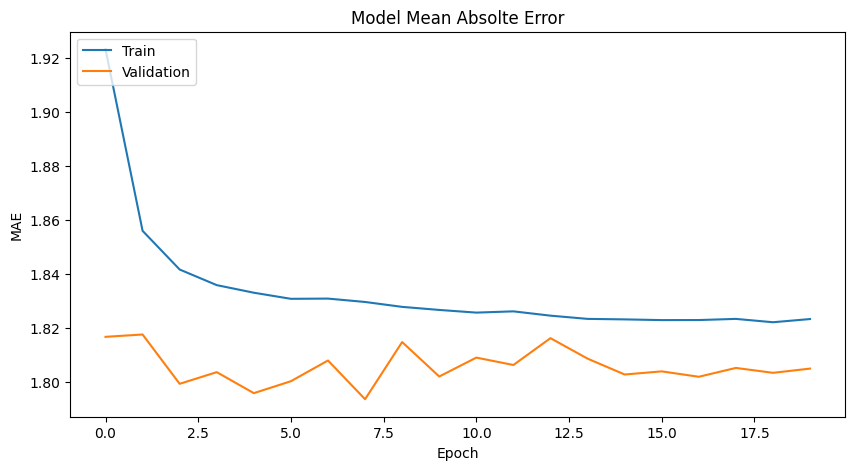

In [108]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolte Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()